# Best TAS Run Replica
This notebook executes the run to retrieve predictions for surface air temperature, using ClimaX. If you are running on your own, please make sure to change the paths to match your own runtime.

To submit to the leaderboard, you need to concatenate this with a separate prediction set for precipitation rate.

In [1]:
!git clone https://github.com/kabir-vats/Deep-Climate-Learning.git
!pip install -r Deep-Climate-Learning/requirements.txt

Cloning into 'Deep-Climate-Learning'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 37 (delta 10), reused 28 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 24.93 KiB | 4.99 MiB/s, done.
Resolving deltas: 100% (10/10), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

In [2]:
import sys
sys.path.append('/kaggle/working/Deep-Climate-Learning')

In [3]:
from pytorch_lightning.loggers import WandbLogger
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kabirvats (kabirvats-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
from climate_prediction.data_loader import ClimateDataModule
from climate_prediction.models.ClimaX_Transformer import ClimaX
from climate_prediction.train import ClimateEmulationModule
from climate_prediction.util import compare_preds
import lightning.pytorch as pl
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
config = {
    "data": {
        "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas"],
        "train_member_ids": [0],
        "val_member_id": 0,
        "target_member_id": 0,
        "train_ssps": ["ssp370", "ssp126", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "val_months": 120,
        "batch_size": 32,
        "num_workers": 4,
        "sequence_length": 1,
    },
    "optimizer": {
        "lr": 2e-4,
        "scheduler": {
            "type": "OneCycle",
            "max_lr": 2e-4,
            "epochs": 60,
            "pct_start": 0.1,
            "anneal_strategy": 'cos',
            "div_factor": 10,
            "final_div_factor": 1e3,
            "cycle_momentum": False,
            'three_phase': False,
        }
    },
    "trainer": {
        "max_epochs": 60,
        "accelerator": "auto",
        "devices": "auto",
        "precision": "32",
        "deterministic": False,
        "num_sanity_val_steps": 0,
    },
    "model_type": "ClimaX",
    "model": {
        "in_vars": ['1','2','3','4','5','6','7','8','9','10', '11', '12'],
        "out_vars": ['TAS'],
        "lat": 48,
        "lon": 72,
        "time_history": 1,
        "patch_size": 8,
        "drop_path": 0.1,
        "drop_rate": 0.1,
        "channel_agg": "attention",
        "embed_dim": 1024,
        "depth": 24,
        "decoder_depth": 8,
        "num_heads": 16,
        "init_mode": "xavier",
        "mlp_ratio": 4.0,
        "freeze_encoder": False
    },
    "loss": {
        "version": "L1_Custom",
        "train_weights": {
            "tas": {"L1": 1, "time_mean": 0, "time_std": 1.0},
            "pr": {"L1": 1, "time_mean": 0, "time_std": 0.75},
        },
    },
    "seed": 42,
}

pl.seed_everything(config["seed"])

INFO: Seed set to 42


42

In [14]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=0
)

wandb_logger = WandbLogger(
    project="HK(N+1)",
    name="TAS with ClimaX",
    config=config                    
)

early_stop_callback = EarlyStopping(
    monitor="val/loss/crit2",   # the metric to monitor
    min_delta=0.0001,            # minimum change to qualify as improvement
    patience=10,                 # how many epochs to wait before stopping
    verbose=True,
    mode="min"                  # minimize the metric
)

datamodule = ClimateDataModule(**config["data"])
model = ClimaX(**config["model"])
lightning_module = ClimateEmulationModule(model, config["data"]["output_vars"], config["loss"], config["optimizer"])

trainer = pl.Trainer(**config["trainer"], logger=wandb_logger, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(lightning_module, datamodule=datamodule)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


['tas']


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                    | Params | Mode 
---------------------------------------------------------------
0 | model      | ClimaX                  | 307 M  | train
1 | criterion  | L1CustomLoss            | 0      | train
2 | criterion1 | L1Loss                  | 0      | train
3 | criterion2 | AreaWeightedClimateLoss | 0      | train
---------------------------------------------------------------
307 M     Trainable params
68.6 K    Non-trainable params
307 M     Total params
1,229.787 Total estimated model params size (MB)
554       Modules in train mode
0         Modules in eval mode


Using one cycle LR


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=4.9953, Criterion2 (Custom)=3.2170
[VAL] tas: RMSE=5.6273, Time-Mean RMSE=4.1504, Time-Stddev MAE=1.7593
[Epoch 1] Current LR (group 0): 3.210051099487179e-05
[TRAIN]: Criterion1 (MSE)=13.1312, Criterion2 (Custom)=8.4230


INFO: Metric val/loss/crit2 improved. New best score: 3.217


[TRAIN] tas: RMSE=14.3045, Time-Mean RMSE=9.7167, Time-Stddev MAE=5.9067


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=4.1644, Criterion2 (Custom)=2.8309
[VAL] tas: RMSE=4.7973, Time-Mean RMSE=3.7147, Time-Stddev MAE=1.4874
[Epoch 2] Current LR (group 0): 6.514821361644241e-05
[TRAIN]: Criterion1 (MSE)=4.8552, Criterion2 (Custom)=2.5680


INFO: Metric val/loss/crit2 improved by 0.386 >= min_delta = 0.0001. New best score: 2.831


[TRAIN] tas: RMSE=5.5225, Time-Mean RMSE=3.0536, Time-Stddev MAE=1.5548


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=3.5875, Criterion2 (Custom)=2.5231
[VAL] tas: RMSE=4.3316, Time-Mean RMSE=3.6438, Time-Stddev MAE=0.9852
[Epoch 3] Current LR (group 0): 0.00011025657255521035
[TRAIN]: Criterion1 (MSE)=3.6678, Criterion2 (Custom)=2.0232


INFO: Metric val/loss/crit2 improved by 0.308 >= min_delta = 0.0001. New best score: 2.523


[TRAIN] tas: RMSE=4.3975, Time-Mean RMSE=2.3346, Time-Stddev MAE=1.2876


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=3.5276, Criterion2 (Custom)=2.4164
[VAL] tas: RMSE=4.2098, Time-Mean RMSE=3.7322, Time-Stddev MAE=0.6917
[Epoch 4] Current LR (group 0): 0.00015529593907119378
[TRAIN]: Criterion1 (MSE)=3.1848, Criterion2 (Custom)=1.7136


INFO: Metric val/loss/crit2 improved by 0.107 >= min_delta = 0.0001. New best score: 2.416


[TRAIN] tas: RMSE=3.8866, Time-Mean RMSE=1.8909, Time-Stddev MAE=1.1484


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=2.4049, Criterion2 (Custom)=1.6653
[VAL] tas: RMSE=2.9823, Time-Mean RMSE=2.4497, Time-Stddev MAE=0.5836
[Epoch 5] Current LR (group 0): 0.00018815521650375442
[TRAIN]: Criterion1 (MSE)=2.9060, Criterion2 (Custom)=1.4824


INFO: Metric val/loss/crit2 improved by 0.751 >= min_delta = 0.0001. New best score: 1.665


[TRAIN] tas: RMSE=3.5334, Time-Mean RMSE=1.6044, Time-Stddev MAE=1.0045


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=2.4131, Criterion2 (Custom)=1.6066
[VAL] tas: RMSE=2.9188, Time-Mean RMSE=2.3767, Time-Stddev MAE=0.5482
[Epoch 6] Current LR (group 0): 0.00019999998000768302
[TRAIN]: Criterion1 (MSE)=2.6095, Criterion2 (Custom)=1.2226


INFO: Metric val/loss/crit2 improved by 0.059 >= min_delta = 0.0001. New best score: 1.607


[TRAIN] tas: RMSE=3.1598, Time-Mean RMSE=1.2817, Time-Stddev MAE=0.8450


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=2.0335, Criterion2 (Custom)=1.3429
[VAL] tas: RMSE=2.5191, Time-Mean RMSE=2.0729, Time-Stddev MAE=0.3607
[Epoch 7] Current LR (group 0): 0.00019982713627560896
[TRAIN]: Criterion1 (MSE)=2.3503, Criterion2 (Custom)=0.9624


INFO: Metric val/loss/crit2 improved by 0.264 >= min_delta = 0.0001. New best score: 1.343


[TRAIN] tas: RMSE=2.8131, Time-Mean RMSE=0.9332, Time-Stddev MAE=0.7074


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.7809, Criterion2 (Custom)=1.0365
[VAL] tas: RMSE=2.0676, Time-Mean RMSE=1.5403, Time-Stddev MAE=0.3326
[Epoch 8] Current LR (group 0): 0.00019931654295074768
[TRAIN]: Criterion1 (MSE)=1.8341, Criterion2 (Custom)=0.6111


INFO: Metric val/loss/crit2 improved by 0.306 >= min_delta = 0.0001. New best score: 1.037


[TRAIN] tas: RMSE=2.1679, Time-Mean RMSE=0.6808, Time-Stddev MAE=0.3241


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.5207, Criterion2 (Custom)=0.8861
[VAL] tas: RMSE=1.8057, Time-Mean RMSE=1.2239, Time-Stddev MAE=0.3720
[Epoch 9] Current LR (group 0): 0.0001984699277192861
[TRAIN]: Criterion1 (MSE)=1.7102, Criterion2 (Custom)=0.4781


INFO: Metric val/loss/crit2 improved by 0.150 >= min_delta = 0.0001. New best score: 0.886


[TRAIN] tas: RMSE=2.0015, Time-Mean RMSE=0.5047, Time-Stddev MAE=0.2512


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.3727, Criterion2 (Custom)=0.6872
[VAL] tas: RMSE=1.6159, Time-Mean RMSE=0.9599, Time-Stddev MAE=0.2566
[Epoch 10] Current LR (group 0): 0.00019729015525917772
[TRAIN]: Criterion1 (MSE)=1.5943, Criterion2 (Custom)=0.3927


INFO: Metric val/loss/crit2 improved by 0.199 >= min_delta = 0.0001. New best score: 0.687


[TRAIN] tas: RMSE=1.8611, Time-Mean RMSE=0.3861, Time-Stddev MAE=0.2131


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.3430, Criterion2 (Custom)=0.6512
[VAL] tas: RMSE=1.5749, Time-Mean RMSE=0.9172, Time-Stddev MAE=0.2323
[Epoch 11] Current LR (group 0): 0.00019578121754697936
[TRAIN]: Criterion1 (MSE)=1.5170, Criterion2 (Custom)=0.3329


INFO: Metric val/loss/crit2 improved by 0.036 >= min_delta = 0.0001. New best score: 0.651


[TRAIN] tas: RMSE=1.7741, Time-Mean RMSE=0.3061, Time-Stddev MAE=0.1825


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2588, Criterion2 (Custom)=0.5857
[VAL] tas: RMSE=1.4780, Time-Mean RMSE=0.7790, Time-Stddev MAE=0.2505
[Epoch 12] Current LR (group 0): 0.00019394822035026616
[TRAIN]: Criterion1 (MSE)=1.4490, Criterion2 (Custom)=0.2790


INFO: Metric val/loss/crit2 improved by 0.066 >= min_delta = 0.0001. New best score: 0.586


[TRAIN] tas: RMSE=1.6833, Time-Mean RMSE=0.2385, Time-Stddev MAE=0.1517


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2966, Criterion2 (Custom)=0.6635
[VAL] tas: RMSE=1.5588, Time-Mean RMSE=0.9379, Time-Stddev MAE=0.2342
[Epoch 13] Current LR (group 0): 0.00019179736595133017
[TRAIN]: Criterion1 (MSE)=1.4445, Criterion2 (Custom)=0.2612
[TRAIN] tas: RMSE=1.6780, Time-Mean RMSE=0.2025, Time-Stddev MAE=0.1528


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2644, Criterion2 (Custom)=0.6338
[VAL] tas: RMSE=1.5040, Time-Mean RMSE=0.8935, Time-Stddev MAE=0.2253
[Epoch 14] Current LR (group 0): 0.0001893359321606205
[TRAIN]: Criterion1 (MSE)=1.3963, Criterion2 (Custom)=0.2278
[TRAIN] tas: RMSE=1.6202, Time-Mean RMSE=0.1665, Time-Stddev MAE=0.1284


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2952, Criterion2 (Custom)=0.6522
[VAL] tas: RMSE=1.5087, Time-Mean RMSE=0.8827, Time-Stddev MAE=0.2774
[Epoch 15] Current LR (group 0): 0.00018657224769093645
[TRAIN]: Criterion1 (MSE)=1.3719, Criterion2 (Custom)=0.2120
[TRAIN] tas: RMSE=1.5943, Time-Mean RMSE=0.1399, Time-Stddev MAE=0.1256


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1796, Criterion2 (Custom)=0.5264
[VAL] tas: RMSE=1.3919, Time-Mean RMSE=0.7045, Time-Stddev MAE=0.2124
[Epoch 16] Current LR (group 0): 0.00018351566397569968
[TRAIN]: Criterion1 (MSE)=1.3112, Criterion2 (Custom)=0.1851


INFO: Metric val/loss/crit2 improved by 0.059 >= min_delta = 0.0001. New best score: 0.526


[TRAIN] tas: RMSE=1.5258, Time-Mean RMSE=0.1217, Time-Stddev MAE=0.0970


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2191, Criterion2 (Custom)=0.5574
[VAL] tas: RMSE=1.4221, Time-Mean RMSE=0.7418, Time-Stddev MAE=0.2362
[Epoch 17] Current LR (group 0): 0.00018017652352666385
[TRAIN]: Criterion1 (MSE)=1.2928, Criterion2 (Custom)=0.1775
[TRAIN] tas: RMSE=1.5074, Time-Mean RMSE=0.1074, Time-Stddev MAE=0.0982


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1422, Criterion2 (Custom)=0.4602
[VAL] tas: RMSE=1.3381, Time-Mean RMSE=0.5698, Time-Stddev MAE=0.2248
[Epoch 18] Current LR (group 0): 0.00017656612493812846
[TRAIN]: Criterion1 (MSE)=1.2625, Criterion2 (Custom)=0.1640


INFO: Metric val/loss/crit2 improved by 0.066 >= min_delta = 0.0001. New best score: 0.460


[TRAIN] tas: RMSE=1.4718, Time-Mean RMSE=0.0971, Time-Stddev MAE=0.0851


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.4219, Criterion2 (Custom)=0.7733
[VAL] tas: RMSE=1.6694, Time-Mean RMSE=1.1723, Time-Stddev MAE=0.2113
[Epoch 19] Current LR (group 0): 0.00017269668465607244
[TRAIN]: Criterion1 (MSE)=1.2203, Criterion2 (Custom)=0.1490
[TRAIN] tas: RMSE=1.4297, Time-Mean RMSE=0.0849, Time-Stddev MAE=0.0716


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1561, Criterion2 (Custom)=0.5110
[VAL] tas: RMSE=1.3758, Time-Mean RMSE=0.6952, Time-Stddev MAE=0.1920
[Epoch 20] Current LR (group 0): 0.0001685812956415678
[TRAIN]: Criterion1 (MSE)=1.2326, Criterion2 (Custom)=0.1476
[TRAIN] tas: RMSE=1.4392, Time-Mean RMSE=0.0821, Time-Stddev MAE=0.0707


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1628, Criterion2 (Custom)=0.5299
[VAL] tas: RMSE=1.3853, Time-Mean RMSE=0.6996, Time-Stddev MAE=0.2270
[Epoch 21] Current LR (group 0): 0.0001642338830683439
[TRAIN]: Criterion1 (MSE)=1.1856, Criterion2 (Custom)=0.1351
[TRAIN] tas: RMSE=1.3921, Time-Mean RMSE=0.0751, Time-Stddev MAE=0.0576


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1311, Criterion2 (Custom)=0.4645
[VAL] tas: RMSE=1.3294, Time-Mean RMSE=0.6055, Time-Stddev MAE=0.1965
[Epoch 22] Current LR (group 0): 0.00015966915720440762
[TRAIN]: Criterion1 (MSE)=1.1967, Criterion2 (Custom)=0.1373
[TRAIN] tas: RMSE=1.3997, Time-Mean RMSE=0.0721, Time-Stddev MAE=0.0646


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1222, Criterion2 (Custom)=0.4713
[VAL] tas: RMSE=1.3376, Time-Mean RMSE=0.6079, Time-Stddev MAE=0.2070
[Epoch 23] Current LR (group 0): 0.00015490256363715252
[TRAIN]: Criterion1 (MSE)=1.1856, Criterion2 (Custom)=0.1306
[TRAIN] tas: RMSE=1.3892, Time-Mean RMSE=0.0658, Time-Stddev MAE=0.0583


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1107, Criterion2 (Custom)=0.4403
[VAL] tas: RMSE=1.3103, Time-Mean RMSE=0.5483, Time-Stddev MAE=0.2056
[Epoch 24] Current LR (group 0): 0.00014995023101038062
[TRAIN]: Criterion1 (MSE)=1.1538, Criterion2 (Custom)=0.1217


INFO: Metric val/loss/crit2 improved by 0.020 >= min_delta = 0.0001. New best score: 0.440


[TRAIN] tas: RMSE=1.3549, Time-Mean RMSE=0.0649, Time-Stddev MAE=0.0453


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1020, Criterion2 (Custom)=0.4279
[VAL] tas: RMSE=1.3044, Time-Mean RMSE=0.5473, Time-Stddev MAE=0.1806
[Epoch 25] Current LR (group 0): 0.00014482891645007702
[TRAIN]: Criterion1 (MSE)=1.1494, Criterion2 (Custom)=0.1197


INFO: Metric val/loss/crit2 improved by 0.012 >= min_delta = 0.0001. New best score: 0.428


[TRAIN] tas: RMSE=1.3529, Time-Mean RMSE=0.0633, Time-Stddev MAE=0.0430


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0385, Criterion2 (Custom)=0.3664
[VAL] tas: RMSE=1.2501, Time-Mean RMSE=0.4286, Time-Stddev MAE=0.1834
[Epoch 26] Current LR (group 0): 0.00013955594886359986
[TRAIN]: Criterion1 (MSE)=1.1266, Criterion2 (Custom)=0.1120


INFO: Metric val/loss/crit2 improved by 0.062 >= min_delta = 0.0001. New best score: 0.366


[TRAIN] tas: RMSE=1.3265, Time-Mean RMSE=0.0567, Time-Stddev MAE=0.0367


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1042, Criterion2 (Custom)=0.4509
[VAL] tas: RMSE=1.3107, Time-Mean RMSE=0.5802, Time-Stddev MAE=0.2000
[Epoch 27] Current LR (group 0): 0.00013414917030414318
[TRAIN]: Criterion1 (MSE)=1.1120, Criterion2 (Custom)=0.1087
[TRAIN] tas: RMSE=1.3129, Time-Mean RMSE=0.0565, Time-Stddev MAE=0.0319


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0541, Criterion2 (Custom)=0.3920
[VAL] tas: RMSE=1.2660, Time-Mean RMSE=0.4854, Time-Stddev MAE=0.1799
[Epoch 28] Current LR (group 0): 0.0001286268755988769
[TRAIN]: Criterion1 (MSE)=1.0948, Criterion2 (Custom)=0.1082
[TRAIN] tas: RMSE=1.2981, Time-Mean RMSE=0.0566, Time-Stddev MAE=0.0325


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0454, Criterion2 (Custom)=0.3703
[VAL] tas: RMSE=1.2505, Time-Mean RMSE=0.4602, Time-Stddev MAE=0.1644
[Epoch 29] Current LR (group 0): 0.00012300775044504235
[TRAIN]: Criterion1 (MSE)=1.1324, Criterion2 (Custom)=0.1159
[TRAIN] tas: RMSE=1.3382, Time-Mean RMSE=0.0554, Time-Stddev MAE=0.0448


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0452, Criterion2 (Custom)=0.3713
[VAL] tas: RMSE=1.2422, Time-Mean RMSE=0.4457, Time-Stddev MAE=0.1802
[Epoch 30] Current LR (group 0): 0.00011731080818346808
[TRAIN]: Criterion1 (MSE)=1.0807, Criterion2 (Custom)=0.1051
[TRAIN] tas: RMSE=1.2820, Time-Mean RMSE=0.0550, Time-Stddev MAE=0.0295


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0571, Criterion2 (Custom)=0.3870
[VAL] tas: RMSE=1.2637, Time-Mean RMSE=0.4736, Time-Stddev MAE=0.1819
[Epoch 31] Current LR (group 0): 0.00011155532546344263
[TRAIN]: Criterion1 (MSE)=1.0765, Criterion2 (Custom)=0.1023
[TRAIN] tas: RMSE=1.2771, Time-Mean RMSE=0.0499, Time-Stddev MAE=0.0294


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.1116, Criterion2 (Custom)=0.4314
[VAL] tas: RMSE=1.2885, Time-Mean RMSE=0.5754, Time-Stddev MAE=0.1660
[Epoch 32] Current LR (group 0): 0.00010576077701663553
[TRAIN]: Criterion1 (MSE)=1.0686, Criterion2 (Custom)=0.0999
[TRAIN] tas: RMSE=1.2687, Time-Mean RMSE=0.0496, Time-Stddev MAE=0.0260


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0452, Criterion2 (Custom)=0.3937
[VAL] tas: RMSE=1.2541, Time-Mean RMSE=0.5024, Time-Stddev MAE=0.1714
[Epoch 33] Current LR (group 0): 9.994676976076963e-05
[TRAIN]: Criterion1 (MSE)=1.0693, Criterion2 (Custom)=0.0992
[TRAIN] tas: RMSE=1.2695, Time-Mean RMSE=0.0475, Time-Stddev MAE=0.0262


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0757, Criterion2 (Custom)=0.4303
[VAL] tas: RMSE=1.2792, Time-Mean RMSE=0.5743, Time-Stddev MAE=0.1621
[Epoch 34] Current LR (group 0): 9.413297645601827e-05
[TRAIN]: Criterion1 (MSE)=1.0480, Criterion2 (Custom)=0.0989
[TRAIN] tas: RMSE=1.2478, Time-Mean RMSE=0.0506, Time-Stddev MAE=0.0251


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9915, Criterion2 (Custom)=0.3146
[VAL] tas: RMSE=1.1929, Time-Mean RMSE=0.3480, Time-Stddev MAE=0.1678
[Epoch 35] Current LR (group 0): 8.833906913861176e-05
[TRAIN]: Criterion1 (MSE)=1.0460, Criterion2 (Custom)=0.0996


INFO: Metric val/loss/crit2 improved by 0.052 >= min_delta = 0.0001. New best score: 0.315


[TRAIN] tas: RMSE=1.2477, Time-Mean RMSE=0.0497, Time-Stddev MAE=0.0272


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9840, Criterion2 (Custom)=0.3095
[VAL] tas: RMSE=1.1847, Time-Mean RMSE=0.3222, Time-Stddev MAE=0.1817
[Epoch 36] Current LR (group 0): 8.258465255689415e-05
[TRAIN]: Criterion1 (MSE)=1.0425, Criterion2 (Custom)=0.0983


INFO: Metric val/loss/crit2 improved by 0.005 >= min_delta = 0.0001. New best score: 0.309


[TRAIN] tas: RMSE=1.2449, Time-Mean RMSE=0.0495, Time-Stddev MAE=0.0252


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0471, Criterion2 (Custom)=0.3898
[VAL] tas: RMSE=1.2471, Time-Mean RMSE=0.4762, Time-Stddev MAE=0.1848
[Epoch 37] Current LR (group 0): 7.688919783506036e-05
[TRAIN]: Criterion1 (MSE)=1.0467, Criterion2 (Custom)=0.0985
[TRAIN] tas: RMSE=1.2490, Time-Mean RMSE=0.0498, Time-Stddev MAE=0.0249


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0315, Criterion2 (Custom)=0.3694
[VAL] tas: RMSE=1.2253, Time-Mean RMSE=0.4522, Time-Stddev MAE=0.1701
[Epoch 38] Current LR (group 0): 7.127197658903535e-05
[TRAIN]: Criterion1 (MSE)=1.0303, Criterion2 (Custom)=0.0955
[TRAIN] tas: RMSE=1.2342, Time-Mean RMSE=0.0457, Time-Stddev MAE=0.0245


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0401, Criterion2 (Custom)=0.3790
[VAL] tas: RMSE=1.2359, Time-Mean RMSE=0.4822, Time-Stddev MAE=0.1604
[Epoch 39] Current LR (group 0): 6.57519957174262e-05
[TRAIN]: Criterion1 (MSE)=1.0327, Criterion2 (Custom)=0.0952
[TRAIN] tas: RMSE=1.2344, Time-Mean RMSE=0.0462, Time-Stddev MAE=0.0234


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9742, Criterion2 (Custom)=0.3200
[VAL] tas: RMSE=1.1912, Time-Mean RMSE=0.3634, Time-Stddev MAE=0.1627
[Epoch 40] Current LR (group 0): 6.0347933088193717e-05
[TRAIN]: Criterion1 (MSE)=1.0311, Criterion2 (Custom)=0.0958
[TRAIN] tas: RMSE=1.2343, Time-Mean RMSE=0.0481, Time-Stddev MAE=0.0225


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9925, Criterion2 (Custom)=0.3257
[VAL] tas: RMSE=1.1997, Time-Mean RMSE=0.3853, Time-Stddev MAE=0.1507
[Epoch 41] Current LR (group 0): 5.507807433865955e-05
[TRAIN]: Criterion1 (MSE)=1.0168, Criterion2 (Custom)=0.0962
[TRAIN] tas: RMSE=1.2219, Time-Mean RMSE=0.0479, Time-Stddev MAE=0.0250


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9893, Criterion2 (Custom)=0.3447
[VAL] tas: RMSE=1.2005, Time-Mean RMSE=0.3968, Time-Stddev MAE=0.1754
[Epoch 42] Current LR (group 0): 4.996025100269764e-05
[TRAIN]: Criterion1 (MSE)=1.0156, Criterion2 (Custom)=0.0943
[TRAIN] tas: RMSE=1.2181, Time-Mean RMSE=0.0462, Time-Stddev MAE=0.0233


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9842, Criterion2 (Custom)=0.2947
[VAL] tas: RMSE=1.1924, Time-Mean RMSE=0.3263, Time-Stddev MAE=0.1487
[Epoch 43] Current LR (group 0): 4.501178017446808e-05
[TRAIN]: Criterion1 (MSE)=1.0119, Criterion2 (Custom)=0.0963


INFO: Metric val/loss/crit2 improved by 0.015 >= min_delta = 0.0001. New best score: 0.295


[TRAIN] tas: RMSE=1.2166, Time-Mean RMSE=0.0498, Time-Stddev MAE=0.0241


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9723, Criterion2 (Custom)=0.3114
[VAL] tas: RMSE=1.1846, Time-Mean RMSE=0.3400, Time-Stddev MAE=0.1686
[Epoch 44] Current LR (group 0): 4.024940591285215e-05
[TRAIN]: Criterion1 (MSE)=1.0086, Criterion2 (Custom)=0.0940
[TRAIN] tas: RMSE=1.2134, Time-Mean RMSE=0.0457, Time-Stddev MAE=0.0236


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9722, Criterion2 (Custom)=0.2892
[VAL] tas: RMSE=1.1796, Time-Mean RMSE=0.3074, Time-Stddev MAE=0.1567
[Epoch 45] Current LR (group 0): 3.56892425848571e-05
[TRAIN]: Criterion1 (MSE)=1.0062, Criterion2 (Custom)=0.0951


INFO: Metric val/loss/crit2 improved by 0.005 >= min_delta = 0.0001. New best score: 0.289


[TRAIN] tas: RMSE=1.2100, Time-Mean RMSE=0.0483, Time-Stddev MAE=0.0237


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9673, Criterion2 (Custom)=0.3001
[VAL] tas: RMSE=1.1778, Time-Mean RMSE=0.3279, Time-Stddev MAE=0.1592
[Epoch 46] Current LR (group 0): 3.1346720339699166e-05
[TRAIN]: Criterion1 (MSE)=0.9942, Criterion2 (Custom)=0.0946
[TRAIN] tas: RMSE=1.1986, Time-Mean RMSE=0.0453, Time-Stddev MAE=0.0266


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9593, Criterion2 (Custom)=0.2893
[VAL] tas: RMSE=1.1744, Time-Mean RMSE=0.3156, Time-Stddev MAE=0.1489
[Epoch 47] Current LR (group 0): 2.7236532898062983e-05
[TRAIN]: Criterion1 (MSE)=0.9944, Criterion2 (Custom)=0.0944
[TRAIN] tas: RMSE=1.1986, Time-Mean RMSE=0.0469, Time-Stddev MAE=0.0248


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9571, Criterion2 (Custom)=0.2744
[VAL] tas: RMSE=1.1682, Time-Mean RMSE=0.2900, Time-Stddev MAE=0.1483
[Epoch 48] Current LR (group 0): 2.337258783320193e-05
[TRAIN]: Criterion1 (MSE)=0.9917, Criterion2 (Custom)=0.0958


INFO: Metric val/loss/crit2 improved by 0.015 >= min_delta = 0.0001. New best score: 0.274


[TRAIN] tas: RMSE=1.1982, Time-Mean RMSE=0.0500, Time-Stddev MAE=0.0245


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9598, Criterion2 (Custom)=0.2655
[VAL] tas: RMSE=1.1680, Time-Mean RMSE=0.2758, Time-Stddev MAE=0.1438
[Epoch 49] Current LR (group 0): 1.9767959512112483e-05
[TRAIN]: Criterion1 (MSE)=0.9845, Criterion2 (Custom)=0.0956


INFO: Metric val/loss/crit2 improved by 0.009 >= min_delta = 0.0001. New best score: 0.265


[TRAIN] tas: RMSE=1.1916, Time-Mean RMSE=0.0480, Time-Stddev MAE=0.0267


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9641, Criterion2 (Custom)=0.2837
[VAL] tas: RMSE=1.1738, Time-Mean RMSE=0.3046, Time-Stddev MAE=0.1529
[Epoch 50] Current LR (group 0): 1.6434844856015008e-05
[TRAIN]: Criterion1 (MSE)=0.9807, Criterion2 (Custom)=0.0938
[TRAIN] tas: RMSE=1.1865, Time-Mean RMSE=0.0464, Time-Stddev MAE=0.0255


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9516, Criterion2 (Custom)=0.2630
[VAL] tas: RMSE=1.1614, Time-Mean RMSE=0.2741, Time-Stddev MAE=0.1385
[Epoch 51] Current LR (group 0): 1.338452206983318e-05
[TRAIN]: Criterion1 (MSE)=0.9809, Criterion2 (Custom)=0.0940


INFO: Metric val/loss/crit2 improved by 0.002 >= min_delta = 0.0001. New best score: 0.263


[TRAIN] tas: RMSE=1.1857, Time-Mean RMSE=0.0469, Time-Stddev MAE=0.0253


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9582, Criterion2 (Custom)=0.2632
[VAL] tas: RMSE=1.1657, Time-Mean RMSE=0.2756, Time-Stddev MAE=0.1400
[Epoch 52] Current LR (group 0): 1.0627312480318557e-05
[TRAIN]: Criterion1 (MSE)=0.9786, Criterion2 (Custom)=0.0934
[TRAIN] tas: RMSE=1.1863, Time-Mean RMSE=0.0472, Time-Stddev MAE=0.0237


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9465, Criterion2 (Custom)=0.2528
[VAL] tas: RMSE=1.1547, Time-Mean RMSE=0.2550, Time-Stddev MAE=0.1386
[Epoch 53] Current LR (group 0): 8.172545611947928e-06
[TRAIN]: Criterion1 (MSE)=0.9779, Criterion2 (Custom)=0.0964


INFO: Metric val/loss/crit2 improved by 0.010 >= min_delta = 0.0001. New best score: 0.253


[TRAIN] tas: RMSE=1.1847, Time-Mean RMSE=0.0501, Time-Stddev MAE=0.0272


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9439, Criterion2 (Custom)=0.2484
[VAL] tas: RMSE=1.1531, Time-Mean RMSE=0.2503, Time-Stddev MAE=0.1348
[Epoch 54] Current LR (group 0): 6.028527618765685e-06
[TRAIN]: Criterion1 (MSE)=0.9748, Criterion2 (Custom)=0.0944


INFO: Metric val/loss/crit2 improved by 0.004 >= min_delta = 0.0001. New best score: 0.248


[TRAIN] tas: RMSE=1.1823, Time-Mean RMSE=0.0457, Time-Stddev MAE=0.0278


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9433, Criterion2 (Custom)=0.2515
[VAL] tas: RMSE=1.1538, Time-Mean RMSE=0.2458, Time-Stddev MAE=0.1465
[Epoch 55] Current LR (group 0): 4.202513178987907e-06
[TRAIN]: Criterion1 (MSE)=0.9720, Criterion2 (Custom)=0.0924
[TRAIN] tas: RMSE=1.1786, Time-Mean RMSE=0.0452, Time-Stddev MAE=0.0246


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9439, Criterion2 (Custom)=0.2536
[VAL] tas: RMSE=1.1547, Time-Mean RMSE=0.2521, Time-Stddev MAE=0.1437
[Epoch 56] Current LR (group 0): 2.700680947467557e-06
[TRAIN]: Criterion1 (MSE)=0.9692, Criterion2 (Custom)=0.0940
[TRAIN] tas: RMSE=1.1764, Time-Mean RMSE=0.0453, Time-Stddev MAE=0.0278


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9425, Criterion2 (Custom)=0.2510
[VAL] tas: RMSE=1.1540, Time-Mean RMSE=0.2536, Time-Stddev MAE=0.1383
[Epoch 57] Current LR (group 0): 1.5281126490822957e-06
[TRAIN]: Criterion1 (MSE)=0.9697, Criterion2 (Custom)=0.0941
[TRAIN] tas: RMSE=1.1775, Time-Mean RMSE=0.0482, Time-Stddev MAE=0.0251


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9421, Criterion2 (Custom)=0.2477
[VAL] tas: RMSE=1.1535, Time-Mean RMSE=0.2459, Time-Stddev MAE=0.1389
[Epoch 58] Current LR (group 0): 6.887758837861321e-07
[TRAIN]: Criterion1 (MSE)=0.9664, Criterion2 (Custom)=0.0954


INFO: Metric val/loss/crit2 improved by 0.001 >= min_delta = 0.0001. New best score: 0.248


[TRAIN] tas: RMSE=1.1736, Time-Mean RMSE=0.0464, Time-Stddev MAE=0.0300


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9414, Criterion2 (Custom)=0.2464
[VAL] tas: RMSE=1.1523, Time-Mean RMSE=0.2433, Time-Stddev MAE=0.1385
[Epoch 59] Current LR (group 0): 1.8551070150703273e-07
[TRAIN]: Criterion1 (MSE)=0.9672, Criterion2 (Custom)=0.0928


INFO: Metric val/loss/crit2 improved by 0.001 >= min_delta = 0.0001. New best score: 0.246


[TRAIN] tas: RMSE=1.1749, Time-Mean RMSE=0.0466, Time-Stddev MAE=0.0243


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9411, Criterion2 (Custom)=0.2465
[VAL] tas: RMSE=1.1523, Time-Mean RMSE=0.2435, Time-Stddev MAE=0.1387
[Epoch 60] Current LR (group 0): 2.00199923169931e-08
[TRAIN]: Criterion1 (MSE)=0.9648, Criterion2 (Custom)=0.0934


INFO: `Trainer.fit` stopped: `max_epochs=60` reached.


[TRAIN] tas: RMSE=1.1724, Time-Mean RMSE=0.0457, Time-Stddev MAE=0.0268


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
lr,▂▃▆████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss/crit1,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss/crit2,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/tas/rmse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/tas/time_mean_rmse,█▆▅▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/tas/time_std_mae,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
val/loss,█▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss/crit1,█▇▆▅▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


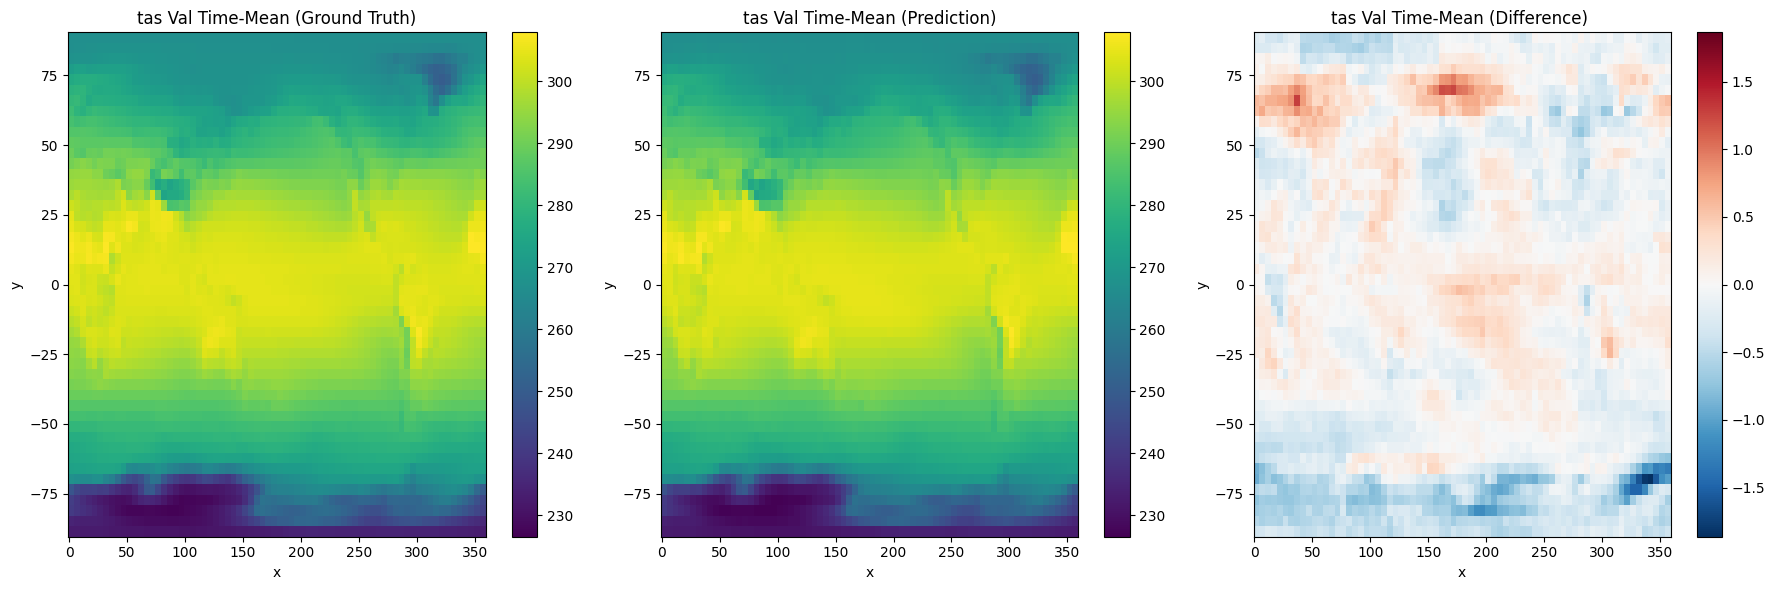

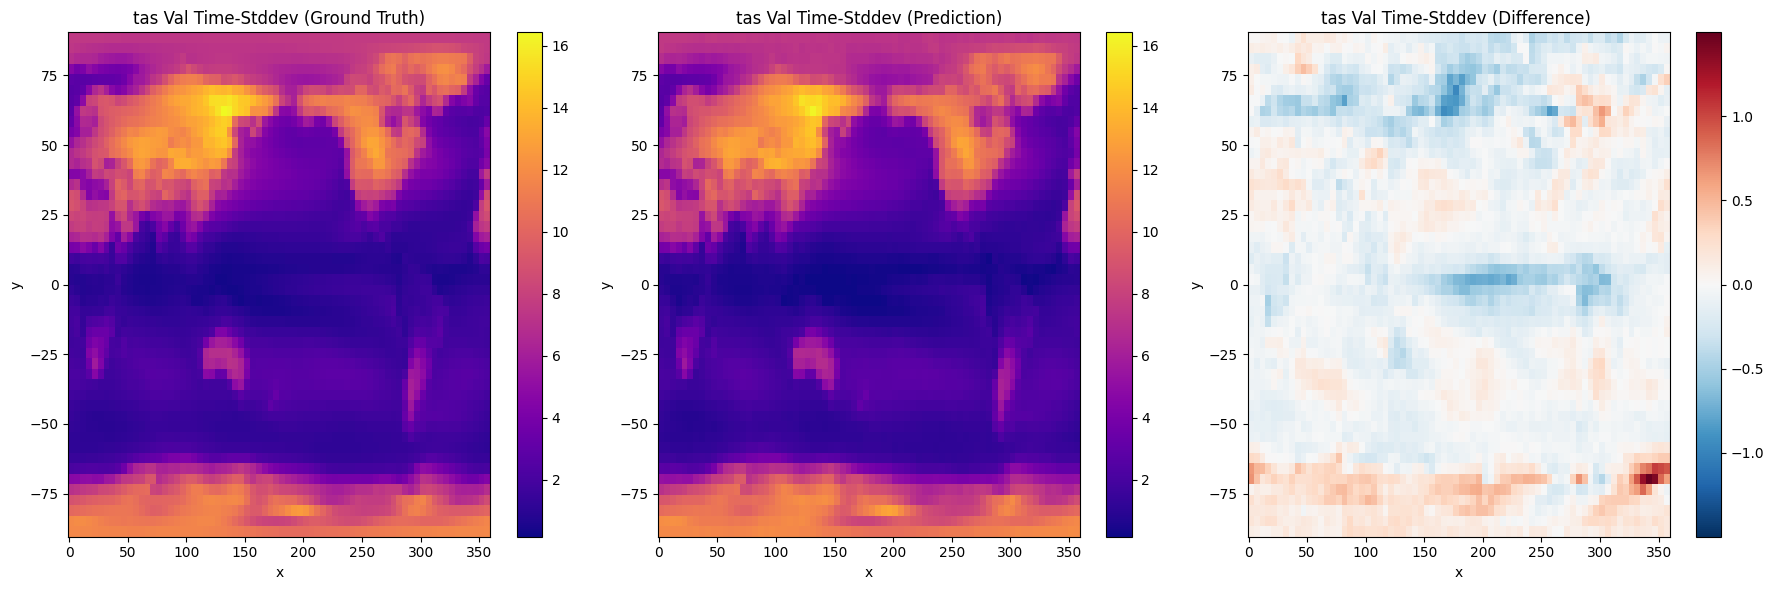

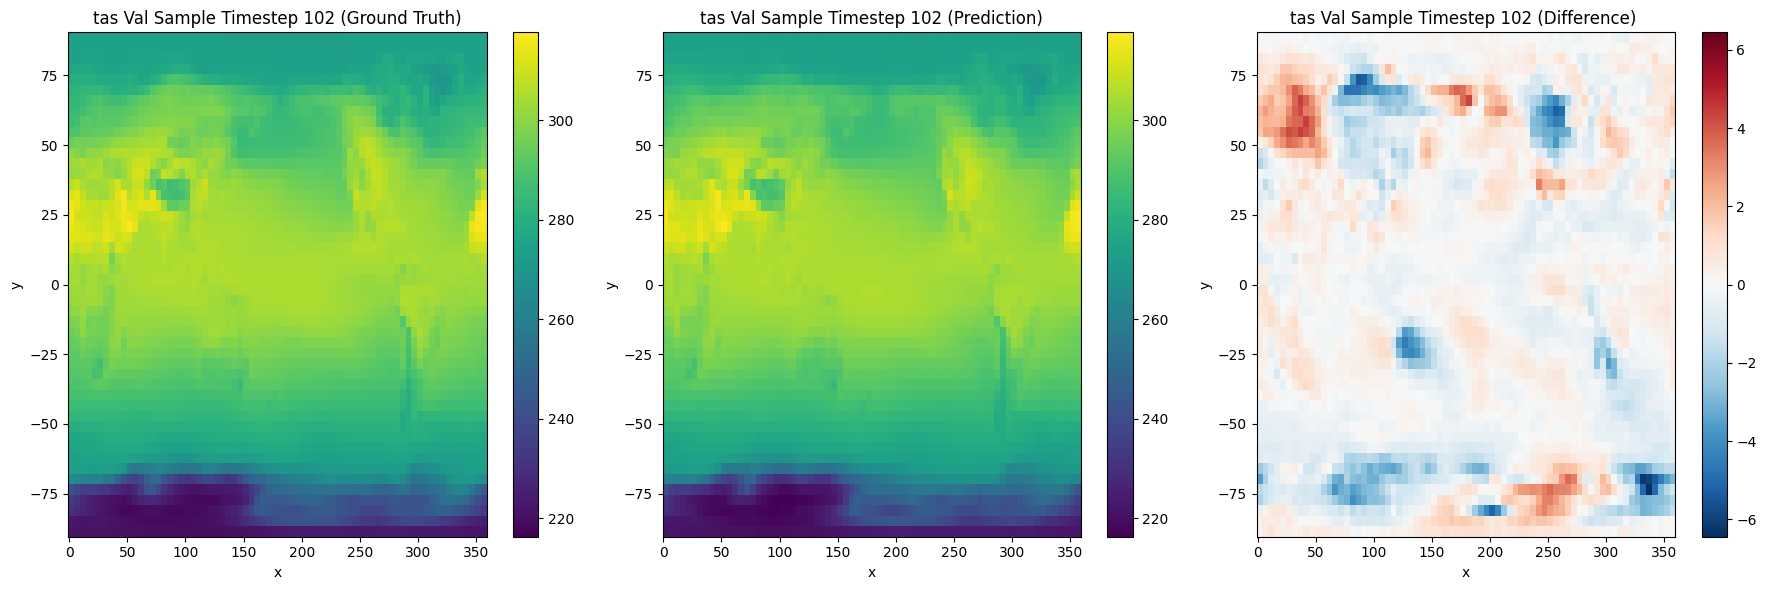

In [15]:
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")
compare_preds(datamodule, val_preds, val_trues)

In [17]:
# To submit:
# trainer = pl.Trainer(**config["trainer"], logger=False)
# trainer.test(lightning_module, datamodule=datamodule)